# Speech Formant Estimation and Clustering using KMeans

In [9]:
import math
import numpy as np
from scipy.io import wavfile
from scipy.signal import lfilter, freqz, find_peaks_cwt
from audiolazy.lazy_lpc import lpc
import peakutils
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8,8)

Speech signals can considered as quasi-stationary over short segments of time even though they are non-stationary. Hence, the properties of speech are defined over short segments of time.

In [2]:
sample_rate, input_data = wavfile.read("speech.wav")
frame_length = 256
num_of_frames = int(len(input_data)/frame_length)

Vocal chords vibration is considered to be the reason for harmonic structure of speech in time-domain and periodic in frequency domain. The formant structure (spectral envelope) of speech is due to the interaction of the source and the vocal tract. The formant structure is characterized by resonant modes of vocal tract called formants and are used in speech synthesis.

The first formant is the fundamental or pitch frequency and is higher for female speakers compared to male.
The formant frequencies describe the distinctive nature of speech and are parameterized and used for recognizing and synthesizing the speech.

The vocal tract is usually represented by a 10th order programmable digital all-pole filter. 

LPC (Linear Predictive Coding) is used to compress and encode the audio signal by using a linear predictive model for predicting the present values by using the linear combination of the past input values. The prediction parameters (vocal tract parameters) are found by minimizing the prediction error in the least squares sense.

In [3]:
formants, formant_1_w, formant_2_w = [], [], []

# Applying operations for overlapping frames of speech signal
for i in range(2*num_of_frames-1):
    frame_min = int(frame_length*i/2)
    frame_max = frame_min + frame_length
    frame_data = input_data[frame_min:frame_max]
    
    # Hamming window output
    hamming_window_output = np.multiply(frame_data, np.hamming(256))

    # Filter output
    filter_output = lfilter(np.array([1]), np.array([1, 0.63]), hamming_window_output)
    
    # Estimating LPC coefficients
    lpc_filter = lpc.kautocor(filter_output, 10)
    formants.append(lpc_filter)
    #     lpc_filter.plot().savefig(str(i)+".jpeg")
    #     plt.close()
    
    # Frequency response of the LPC filter
    w, h = freqz(lpc_filter.numlist)
    
    # Finding the first and second formants
    peak_indices = peakutils.indexes(20*np.log10(abs(h)))
    if peak_indices.size > 1:
        formant_1_w.append(w[peak_indices[0]])
        formant_2_w.append(w[peak_indices[1]])

### Voiced speech formant structure

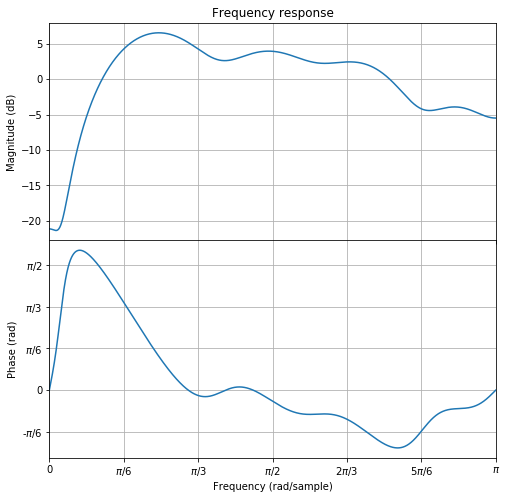

In [10]:
voiced_speech_formant = formants[57].plot()

### Visualizing 1st and 2nd formants

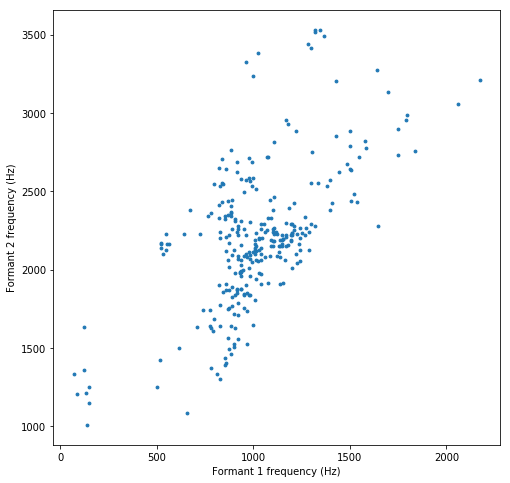

In [11]:
formant_1_Hz = [(x*sample_rate)/(2*math.pi) for x in formant_1_w]
formant_2_Hz = [(x*sample_rate)/(2*math.pi) for x in formant_2_w]
plt.scatter(formant_1_Hz, formant_2_Hz, s=8)
plt.xlabel("Formant 1 frequency (Hz)")
plt.ylabel('Formant 2 frequency (Hz)')
plt.show()

### Formant clustering using KMeans algorithm

In [6]:
X = np.column_stack((formant_1_Hz, formant_2_Hz))

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

The clustered formants can be compared to the formant plot schematic below to know the different types to phonemes in the speech.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/FormantPlotSchematic.JPG/500px-FormantPlotSchematic.JPG" alt="Formant Plot Schematic" align="left"/>

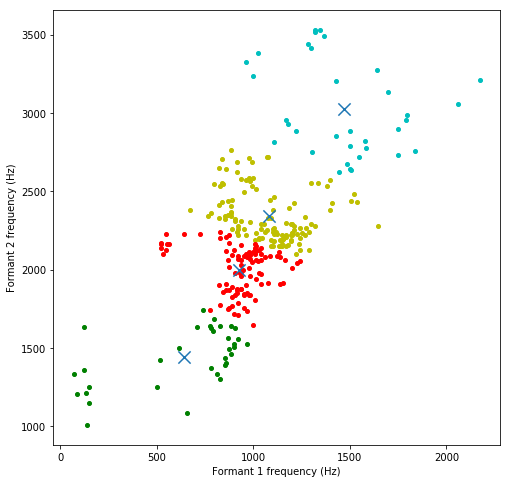

In [12]:
colors = ["g.","r.","c.","y."]

for i in range(len(X)):
#     print("coordinate:",X[i], "label:", labels[i])
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 8)


plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)
plt.xlabel("Formant 1 frequency (Hz)")
plt.ylabel('Formant 2 frequency (Hz)')
plt.show()